In [216]:
from datapackage import Package
import pandas as pd
from tqdm.notebook import tqdm as tqdm
import yfinance as yf
import numpy as np
import missingno
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from communities.algorithms import louvain_method
from sklearn.cluster import KMeans 
from itertools import chain
import investpy
import warnings 

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [6, 3]

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


# Cleaning the data:

First the data is imported from the yfinance library and wikipedia starting from any date.
The data is cleaned by first removing the columns with more than 5% nan values and the rest are filled with the leftmost values. 


In [217]:
def get_data(initial_date,final_date):
    #I start by getting the tickers from wikipedia:
    tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
    #Download them using Yfinance
    data = yf.download(tickers.Symbol.to_list(),initial_date,final_date, auto_adjust=True)['Close']
    #monthly_data = data.resample("M").last()
    #print('Data Shape before cleaning =', monthly_data.shape)
    print('Data Shape before cleaning =', data.shape)
    return(data)

initial_date = '2016-1-1'
final_date = '2024-1-1'
data = get_data(initial_date,final_date)

[*********************100%%**********************]  503 of 503 completed

2 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2016-1-1 -> 2024-1-1)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


Data Shape before cleaning = (2012, 503)


In [218]:
def drop_missing(data,missing_thereshold):
    data_m = data.copy()
    #get the missing percentage in every ticker:
    missing_percentage = data_m.isnull().mean().sort_values(ascending=False)
    #drop tickers based on missin_threshold
    drop_tickers = sorted(list(missing_percentage[missing_percentage > missing_thereshold].index))
    data_m.drop(labels=drop_tickers, axis=1, inplace=True) 
    print('Data Shape after cleaning =', data_m.shape) 
    return(data_m)

missing_thereshold= 0.1 #I dont want tickers missing more than 5% of the data
data_m = drop_missing(data,missing_thereshold)

Data Shape after cleaning = (2012, 482)


In [219]:
#I will fill the remaining nan values with the value to the right
def fill_nan_values(data):
    data = data.ffill()
    clean_data = data.dropna(axis=1, how="any") #if there is still a nan value, drop the column
    print('Data Shape after cleaning =', clean_data.shape)
    return(clean_data)
    
clean_data = fill_nan_values(data_m)

Data Shape after cleaning = (2012, 481)


In [220]:
#I store the dataframe as csv.
desktop_path = "/path/to/your/desktop"
clean_data.to_csv(r'/Users/a00/Desktop/sp500_df.csv', index=False)


In [221]:
training_data, test_data = np.split(clean_data, [int(0.8*len(clean_data))])


/Users/a00/anaconda3/envs/torchEnv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


# Cluster analysis

For the cluster analysis, the stocks are compared to each other by computing the mean and standard devidation of the percentage change of every one. This leads to the returns and volatility formulas respectively. 
$$R = \langle \frac{S(t_1)-S(t_0)}{S(t_0))} \rangle \times \Delta$$
$$V = \sqrt{Var\left( \frac{S(t_1)-S(t_0)}{S(t_0))}\right) \times\Delta} $$
Where delta is the time increment between $t_0$ and $t_1$ and S is the stock being traded.
After computing that, the K-means algorithm is used to cluster similar stocks to each other for a range of between 3 to 15 clusters. For every cluster we then group the assets into a dataframe and thus create a list of dataframes. 

A Hurst exponent greater than 0.5 suggests a trending behavior, while less than 0.5 indicates mean-reverting behavior. It could be added to the clusters

In [222]:
def returns_volatility(training_data):
    X= pd.DataFrame()
    data_pct = training_data.pct_change()
    X['returns'] = data_pct.mean() * 252 #trading days
    X['volatility'] = data_pct.std() * np.sqrt(252)
    
    return X# (np.asarray([np.asarray(returns),np.asarray(volatility)]).T)

X = returns_volatility(training_data)

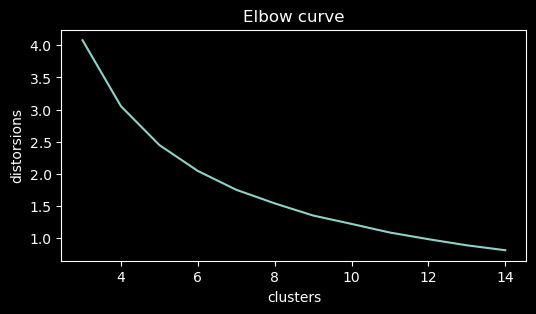

In [223]:
def K_means(X,min_clusters,max_clusters, show_plot = True):
    distorsions = []
    for k in range(min_clusters,max_clusters):
        k_means = KMeans(n_clusters=k,n_init=10)
        k_means.fit(X)
        distorsions.append(k_means.inertia_)

    if show_plot == True:     
        #fig = plt.figure(figsize=(15, 5))
        plt.plot(range(min_clusters, max_clusters), distorsions)
        plt.xlabel("clusters")
        plt.ylabel("distorsions")
        plt.title('Elbow curve')

    return(distorsions)
    
min_clusters,max_clusters = 3,15

distorsions = K_means(X,min_clusters,max_clusters,show_plot = True)


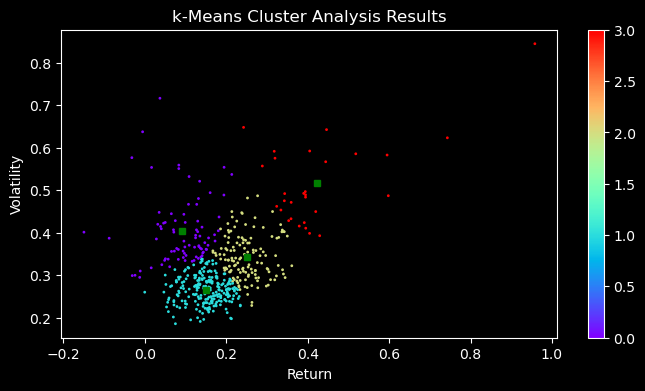

The optimal number of clusters is  4


In [229]:
def optimal_n_clusters(X,distorsions,cluster_num,show_plot = True):
    "The elbow is computed"
    #K = range(min_clusters,max_clusters+1)
    #kl = KneeLocator(K, distorsions, curve="convex", direction="decreasing")
    
    "The data is fitted to make predictions"
    k_means = KMeans(n_clusters=cluster_num ,n_init = 10)
    k_means.fit(X)
    prediction = k_means.predict(X)
    centroids = k_means.cluster_centers_

    if show_plot == True:
        #Plot the results
        fig = plt.figure(figsize = (8,4))
        ax = fig.add_subplot(111)
        scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c=k_means.labels_,s=1, cmap="rainbow", label = X.index)
        ax.set_title('k-Means Cluster Analysis Results')
        ax.set_xlabel('Return')
        ax.set_ylabel('Volatility')
        plt.colorbar(scatter)
        plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=4)
        plt.show()
        
    X['cluster'] = prediction   
    return(X,prediction,centroids)
    
cluster_num=4
X,prediction,centroids = optimal_n_clusters(X,distorsions,cluster_num,show_plot = True)
print("The optimal number of clusters is ",cluster_num)


In [179]:
def df_clusters_grouping(training_data,X,cluster_num):
    tickers_data = list(training_data.columns)
    tickers_X = list(X.index)
    
    df_list = []
    for i in range(cluster_num):
        cluster_data = pd.DataFrame()
        for j in range(len(tickers_X)):
            if i == int(X['cluster'].iloc[j]):
                ticker = X.index[j]
                cluster_data[ticker] = training_data[ticker]
        df_list.append(cluster_data.copy())
    return(df_list)
    
df_list = df_clusters_grouping(training_data,X,cluster_num)


# Correlation analysis:

The aim of the correlation analysis is to further separate data into similar groups. To do so, I implement a correlation and mutual information matrix within each cluster generated above. Then I sum the correlation and mutual information of the links and finally delete 0.6 of the least important links.


Even though the choice is arbitrary it produces good results. 

In [180]:
#here I have the sector information in case I need it
msft = yf.Ticker("A").info.get("sector")
print(msft) 


Healthcare


  0%|          | 0/4 [00:00<?, ?it/s]

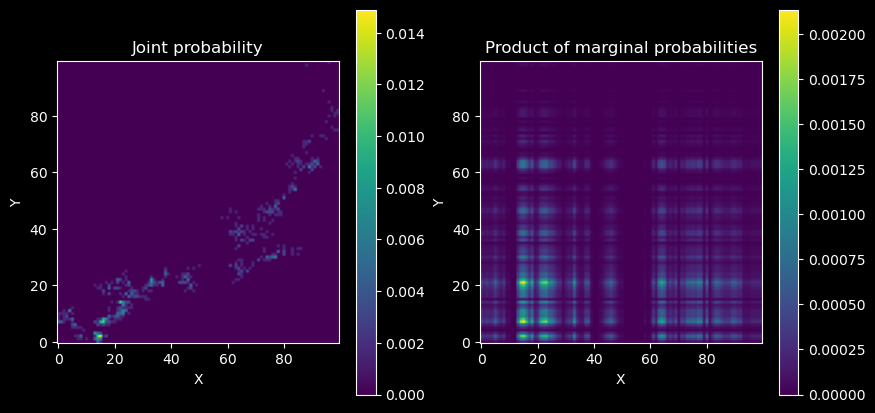

In [231]:
def mutual_relations(df_list,show_plot = True):
    rel_dfs = []
    numBins = 100 # number of bins in each dimension
    epsilon = 1e-10 # a small positive constant
    dimension,_ = df_list[0].shape

    for i in tqdm(range(len(df_list))):
        Mutual_info = []
        for j in (list(df_list[i].columns)):
            a = np.array(df_list[i][j])
            for k in list(df_list[i].columns):
                if k != j: #could we not compute the same twice???????????? k>j!! 
                    data = np.array([np.array(df_list[i][k]), a]).T #np.array([np.array(df_list[i][k]),a]).T
                    jointFreqs, _ = np.histogramdd(data, bins=numBins) # compute the joint frequencies
                    jointProbs = jointFreqs / jointFreqs.sum () # normalize the frequencies to get the joint probabilities
                    marginalProbsX = jointProbs.sum(axis=1) # compute the marginal probabilities of X
                    marginalProbsY = jointProbs.sum(axis=0) # compute the marginal probabilities of Y
                    productProbs = np.outer(marginalProbsX, marginalProbsY) # compute the product of marginal probabilities
                    MI = np.sum(jointProbs * np.log((jointProbs + epsilon) / (productProbs + epsilon)))
                    Mutual_info.append(MI) 

        rel_dfs.append(pd.DataFrame())
        rel_dfs[i] = df_list[i].corr(method='pearson').unstack().reset_index()
        rel_dfs[i] = rel_dfs[i][rel_dfs[i]['level_0'] != rel_dfs[i]['level_1']].reset_index(drop=True)
        rel_dfs[i]['Mutual_information'] = Mutual_info
        rel_dfs[i] = rel_dfs[i].rename(columns={0: 'correlation'})
        rel_dfs[i]['correlation'] = rel_dfs[i]['correlation'].abs() #I want the absolute value
        
    if show_plot == True: #plot of the last one:
        plt.figure (figsize=(10, 5)) # create a figure with a specified size
        plt.subplot (1, 2, 1) # create a subplot on the left
        plt.imshow (jointProbs, cmap='viridis', origin='lower') # plot the joint probabilities as an image
        plt.colorbar () # add a colorbar
        plt.xlabel ('X') # add a label for the x-axis
        plt.ylabel ('Y') # add a label for the y-axis
        plt.title ('Joint probability') # add a title
        plt.subplot (1, 2, 2) # create a subplot on the right
        plt.imshow (productProbs, cmap='viridis', origin='lower') # plot the product of marginal probabilities as an image
        
        plt.colorbar() # add a colorbar 
        ticks = np.linspace(data.min(), data.max(), 2)
        plt.xlabel ('X') # add a label for the x-axis
        plt.ylabel ('Y') # add a label for the y-axis
        plt.title ('Product of marginal probabilities') # add a title
        plt.show () # show the plot
        
    return(rel_dfs)

rel_dfs = mutual_relations(df_list,show_plot = True)


# Null Model:

To check weather there exists correlations I compare them to a null model. After computing the null model for a few shoufled versions of the orginial data, I notice that the Z-score is very high thus indicating that the correlations detected before are not casual. 

#I first build a dataframe list of shuffled dataframes for the null model: 
def dfs_shuffle(df_list):
    shuffled_dfs = []
    for df in df_list: 
        shuffled_df = pd.DataFrame({col: np.random.permutation(df[col]) for col in df.columns})
        shuffled_dfs.append(shuffled_df)
    return(shuffled_dfs)

df_list_shuffled = dfs_shuffle(df_list)
rel_dfs_shuffled = mutual_relations(df_list_shuffled,show_plot = True)


def null_model(df_list,rel_dfs,null_samples):
    
    null_samples = 2

    Corrs =  [[] for i in range(len(df_list))]
    MIs = [[] for i in range(len(df_list))]
    
    for i in range(null_samples):
        df_list_shuffled = dfs_shuffle(df_list)
        rel_dfs_shuffled = mutual_relations(df_list_shuffled,show_plot = False)
        for j in range(len(df_list)):
            Corrs[j].append(list(rel_dfs_shuffled[j]["correlation"]))
            MIs[j].append(list(rel_dfs_shuffled[j]["Mutual_information"]))
    
    Corr_mean =  [[] for i in range(len(rel_dfs))]
    Corr_std =  [[] for i in range(len(rel_dfs))]
    MI_mean =  [[] for i in range(len(rel_dfs))]
    MI_std =  [[] for i in range(len(rel_dfs))]
    
    for i in range(len(df_list)):
        Corr_mean[i] = (np.mean(Corrs[i], axis=0))
        Corr_std[i] = (np.std(Corrs[i], axis=0))
        MI_mean[i] = (np.mean(MIs[i], axis=0))
        MI_std[i] = (np.std(MIs[i], axis=0))
    
    for i in range(len(rel_dfs)):
        rel_dfs[i]['Corr_mean'] = Corr_mean[i]
        rel_dfs[i]['Corr_std'] = Corr_std[i]
        rel_dfs[i]['MI_mean'] = MI_mean[i]
        rel_dfs[i]['MI_std'] = MI_std[i]
    
    for i in range(len(rel_dfs)):
        rel_dfs[i]['Z_Corr'] = (rel_dfs[i]['correlation']-rel_dfs[i]['Corr_mean'])/rel_dfs[i]['Corr_std']
        rel_dfs[i]['Z_MI'] = (rel_dfs[i]['Mutual_information']-rel_dfs[i]['MI_mean'])/rel_dfs[i]['MI_std']

    return(rel_dfs)

null_samples = 2
rel_dfs_withnull = null_model(df_list,rel_dfs,null_samples)

rel_dfs_withnull[0]

value_counts = rel_dfs[0]['level_0'].value_counts() 
print(len(value_counts))  

# Data Filtering: 


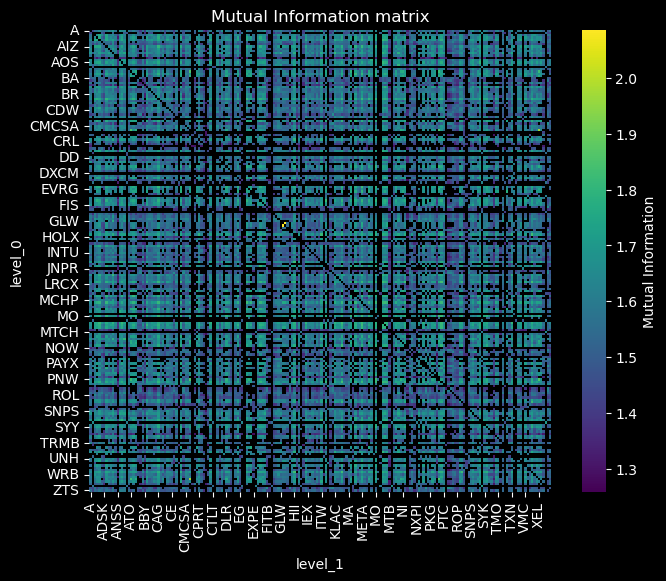

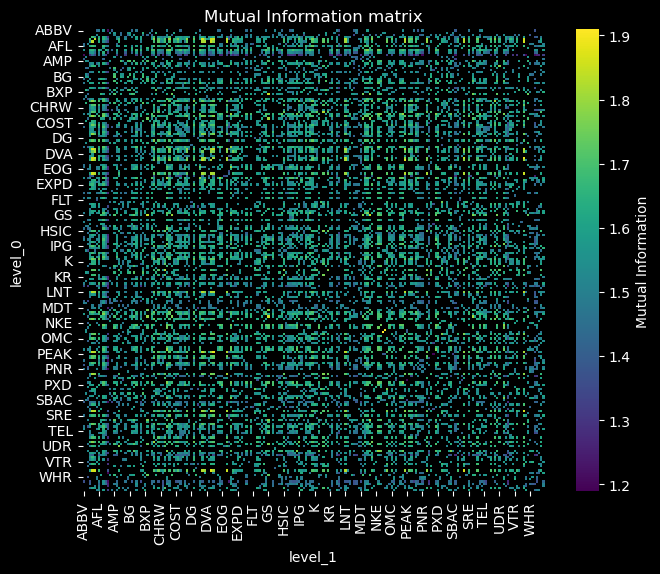

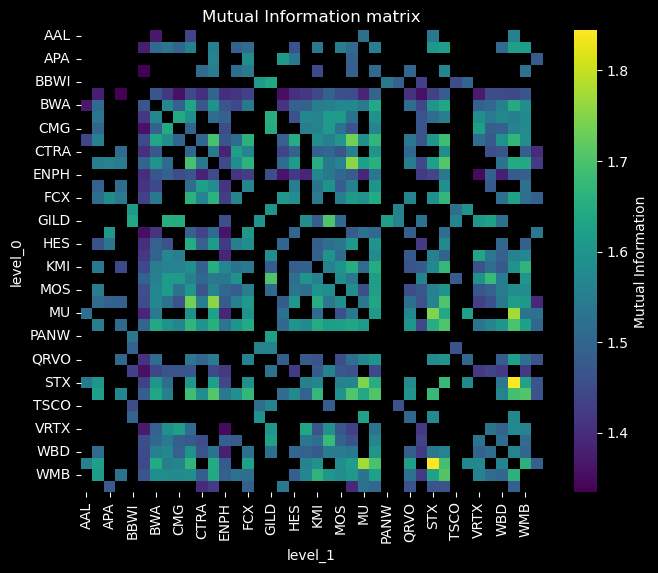

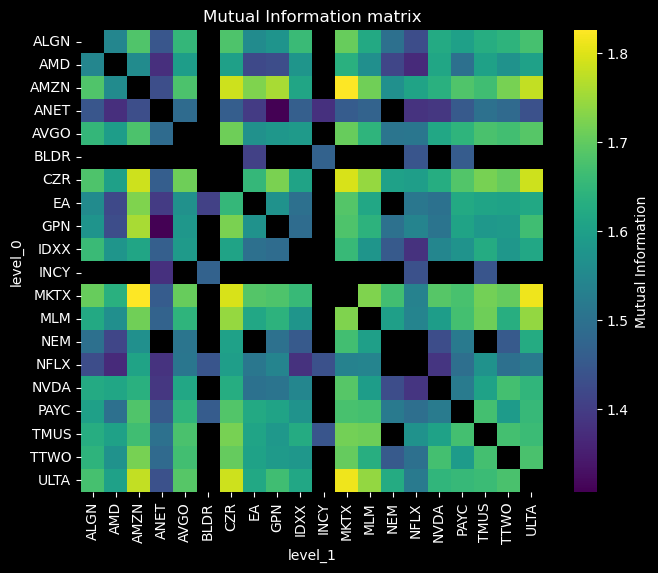

In [182]:
def filter_data(rel_dfs,percent_edges_out,corr_importance,show_plot=True):

    final_dfs = [df.copy() for df in rel_dfs]
    for i in range(len(final_dfs)):
        
        threshold_corr = max(list(final_dfs[i]['correlation']))*percent_edges_out
        final_dfs[i] = final_dfs[i][final_dfs[i]['correlation'] >= threshold_corr]
        threshold_mi = max(list(final_dfs[i]['Mutual_information']))*percent_edges_out
        final_dfs[i] = final_dfs[i][final_dfs[i]['Mutual_information'] >= threshold_mi]
        
        """
        threshold_corr = 0.9
        final_dfs[i].loc[final_dfs[i]['correlation'] < threshold_corr,'correlation'] = 0
        threshold_mi = 1.2
        final_dfs[i].loc[final_dfs[i]['Mutual_information'] < threshold_mi,'Mutual_information'] = 0
        """
        
        final_dfs[i]['linear_MI_C'] = (final_dfs[i]['correlation']*corr_importance +
                                       final_dfs[i]['Mutual_information']*(1-corr_importance))
    
        if show_plot == True:
            heatmap_data = final_dfs[i].pivot(index='level_0', columns='level_1', values='linear_MI_C')
            plt.figure(figsize=(8, 6))
            sns.heatmap(heatmap_data, cmap='viridis', linewidths=0, square=True, cbar_kws={'label': 'Mutual Information'})
            # Show the plot 
            plt.title('Mutual Information matrix') 
            plt.show() 
        
    return(final_dfs)

corr_importance = 0.5
percent_edges_out = 0.6

final_dfs_shuffled = filter_data(rel_dfs,percent_edges_out,corr_importance,show_plot = True)


In [183]:
rel_dfs[0]

,level_0,level_1,correlation,Mutual_information
0,A,AAPL,0.599861,2.246885
1,A,ACGL,0.790946,2.329596
2,A,ACN,0.756206,2.379582
3,A,ADBE,0.890287,2.415047
4,A,ADI,0.851845,2.243583
...,...,...,...,...
41407,ZTS,XEL,0.630307,2.276116
41408,ZTS,XYL,0.791899,2.262721
41409,ZTS,YUM,0.848861,2.279860
41410,ZTS,ZBRA,0.260970,2.323993


# Graph analysis: 

In order to further detect similar clusters of data, I implement the Louvain method to detect communities in every one of the correlation matrices computed above for the respective clusters. Since I want to trade using mean reversion, I need the mean to be significative, that is why if the cluster detected does not have at least 10 stocks in it, I don't use it.

Graph with 204 nodes and 20706 edges
Graph with 98 nodes and 4753 edges
Graph with 106 nodes and 5565 edges


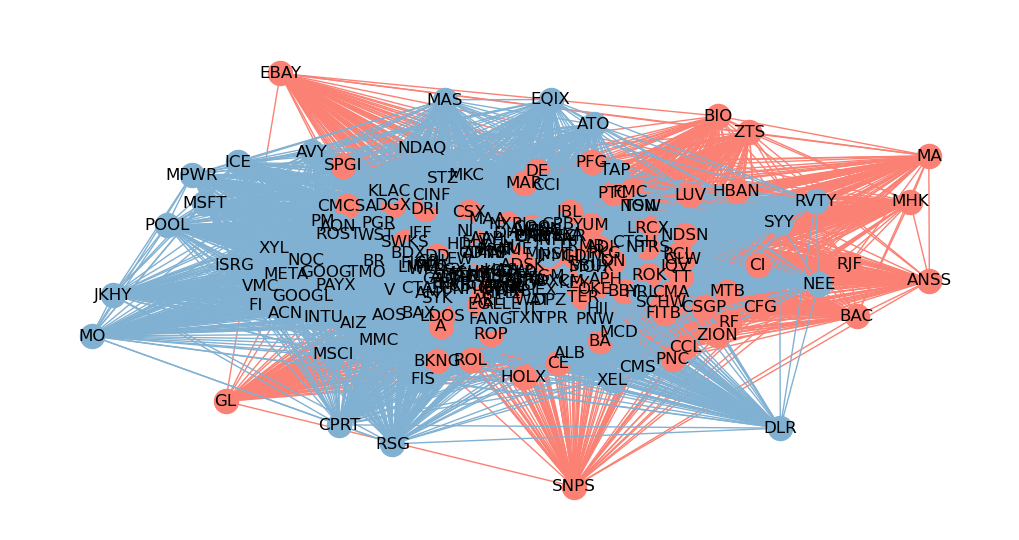

Graph with 211 nodes and 22155 edges
Graph with 90 nodes and 4005 edges
Graph with 25 nodes and 300 edges
Graph with 96 nodes and 4560 edges


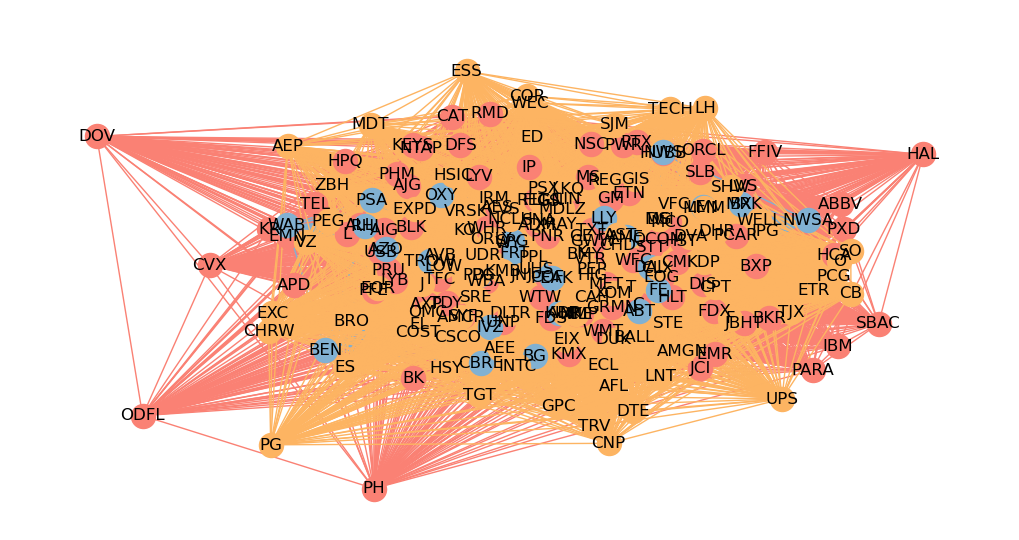

Graph with 41 nodes and 820 edges
Graph with 25 nodes and 300 edges
Graph with 16 nodes and 120 edges


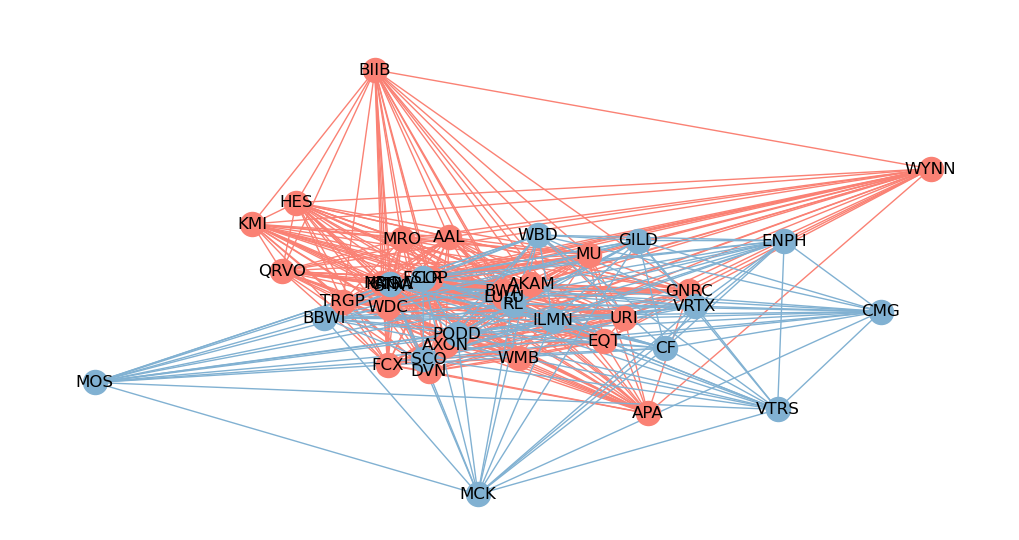

Graph with 20 nodes and 190 edges
Graph with 16 nodes and 120 edges
Graph with 4 nodes and 6 edges


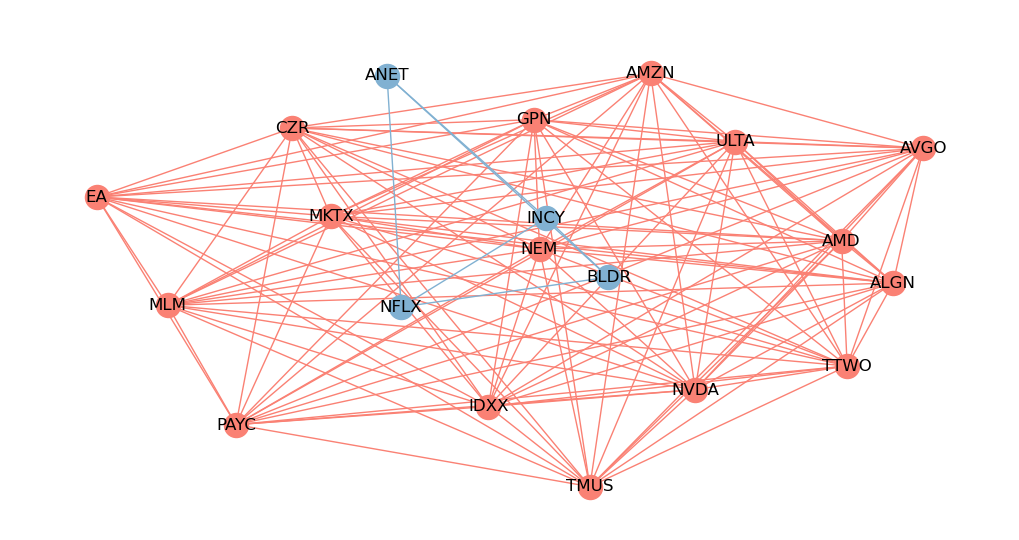

In [184]:
def graph_analysis(rel_dfs,show_plot = True):

    ticker_communities_list = []
    
    for i in range(len(rel_dfs)):
    
        #first: compute the graph
        G = nx.Graph()
        for _, row in rel_dfs[i].iterrows():
            G.add_edge(row['level_0'], row['level_1'], weight=row['correlation'])
        print(G)

        #extracting the adjacency from the graph
        Adj = (nx.adjacency_matrix(G)).todense() 
        #A modularity optimization algorithm: https://www.wikiwand.com/en/Louvain_method
        #Alternatives: https://pypi.org/project/communities/
        communities, _ = louvain_method(Adj) #I get back a list of sets of column indices
        #I create a dictionary of tickers and numbers
        nodes_dict = {key:value for key,value in enumerate(G.nodes)}
        #I reasign the indices back to the ticker name
        ticker_communities = [[nodes_dict[element] for element in s] for s in communities]

        ticker_communities_list.append(ticker_communities)
        
        if show_plot == True: #plot of the last one:
            #plot of full graph:
            #pos = nx.circular_layout(G)
            #nx.draw(G, pos, with_labels=True, node_size=700)
            #plt.show()
            
            # Plot of ach subgraph: 
            pos = nx.kamada_kawai_layout(G)
            for i, community in enumerate(ticker_communities):
                subgraph = G.subgraph(community)
                print(subgraph)
                nx.draw(subgraph, pos, with_labels=True, node_color='C'+str(i+3), edge_color='C'+str(i+3), label=f'Community {i}')
                
            plt.title("Communities in the Graph")
            plt.show()

    return(ticker_communities_list)


ticker_communities_list = graph_analysis(rel_dfs,show_plot = True)


In [232]:
def community_filter(ticker_communities_list, filter_num):
    ticker_list = list(chain(*ticker_communities_list))
    filtered_tickers = [sublist for sublist in ticker_list if len(sublist) > filter_num]
    lens = [len(i) for i in ticker_list]
    lensf= [len(i) for i in filtered_tickers]
    print("Initial lenghts", lens)
    print("Filtered lengths", lensf)
    return(filtered_tickers)

filter_num = 10
filtered_tickers = community_filter(ticker_communities_list,filter_num)

Initial lenghts [98, 106, 90, 25, 96, 25, 16, 16, 4]
Filtered lengths [98, 106, 90, 25, 96, 25, 16, 16]


# Investing without strategy

The time forecast is first tested against simply checking what is the percentage change gain of the market if I invest just at starting testing. 

In [233]:
#Here we get the baskets defined through all this process
def stock_baskets(training_data,filtered_tickers):
    baskets = []
    for tickers in (filtered_tickers):
        baskets.append(training_data[tickers])
    return(baskets)
    
baskets_train = stock_baskets(training_data,filtered_tickers)
baskets_test = stock_baskets(test_data,filtered_tickers)
baskets_total = stock_baskets(clean_data,filtered_tickers)


In [283]:
#now the null model is to test what is won just by investing at every stock 
def time_price(df,c):
    assets = df.columns.tolist()
    for k in tqdm(range(len(assets))):
        ass = (df[assets[2]])
        asset = (df[assets[k]])
        #ass.plot(color='red')
        asset.plot(color=c,alpha = 0.7)
        

In [ ]:
final_prices = []
for basket in range(len(baskets_total)):
    plt.figure(figsize=(16, 4))

    inv_time = len(training_data)-1
    #normalised_data = (baskets_train[basket]-baskets_train[basket].iloc[inv_time])/baskets_train[basket].iloc[inv_time]
    #normalised_data_total = (baskets_total[basket]-baskets_total[basket].iloc[inv_time])/baskets_total[basket].iloc[inv_time]
    normalised_data_total = baskets_total[basket]
    normalised_data = baskets_train[basket]
    final_prices.append(np.mean([normalised_data_total.iloc[-1]]))
    
    time_price(normalised_data_total,"blue")
    #time_price(normalised_data,"blue")
    #plt.axhline(0, color='red', linestyle='--', label='Zero Line')
    plt.show()

In [188]:
print("If I invest at",inv_time,"the PCT change is:",np.mean(final_prices))


If I invest at 603 the PCT change is: 0.17048104526786814


I will set 
1. If it has been above the mean of it's own market value for some window time, it will probably be below (the same happens if it has been below) thus we can arbitrage.
2. If it has been above the mean market value of all the others within the same basket, then it will probably be below after some time. 
3. Since it is mean reverting, we could reinvest the capital gained after some time. That is because it doesn't depend on weather the markets go up or down but on stationarity.

# Trading process:

Now I start calculating the so called super_asset. Notice this is not a real asset but only a relative indication to every asset in the basket what is their position relative to the mean. Not only the mean but a rolling window mean of every other market in the basket. 

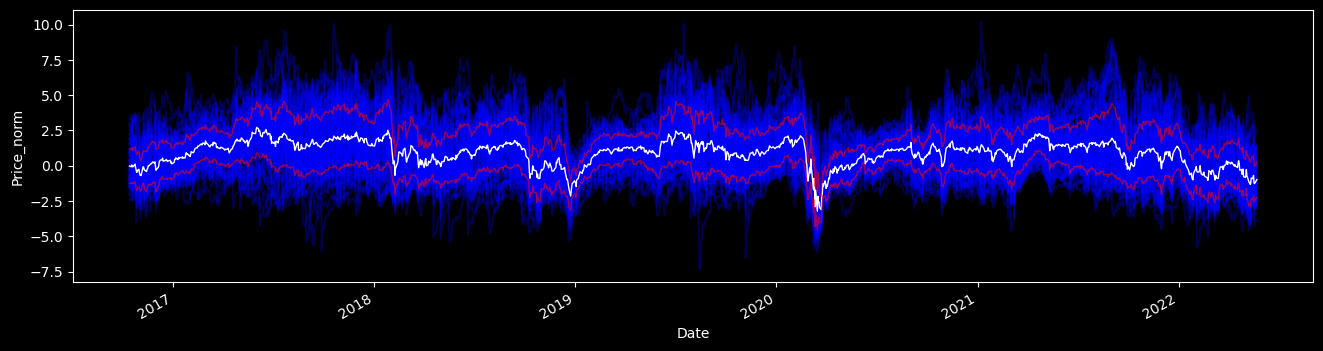

In [257]:
#stationary (Not true dynamics, it hides true price and we can't predict the future) 
#Only the red part is important, the other is training.
from IPython.display import Image, display, HTML

def super_asset_calculation_train(baskets_train,basket_num,window_size,show_plots = False, plot_super_asset = False):
    plt.figure(figsize=(16, 4))

    basket = baskets_train[basket_num]
    
    assets = basket.columns.tolist()
    super_asset = pd.Series(0, index=basket.index) #colum to which all indices are summed.
    std_calculation = []

    stationary_df = pd.DataFrame()
    for asset in (assets):
        
        #calculations
        asset_price = basket[asset]
        asset_rolling = basket[asset].rolling(window_size).mean()
        std_separation = ((asset_price-asset_rolling)).rolling(window_size).std() #this is what is being predicted
        asset_stationary = (asset_price-asset_rolling)/std_separation 
        stationary_df[asset] = asset_stationary
        
        #super
        super_asset += asset_stationary 
        asset_sum = super_asset/len(assets)
        
        std_calculation.append(asset_price.tolist())
        #plots:
        if show_plots == True:
            asset_stationary.plot(color='blue',alpha = 0.3)
            """ 
            plt.axhline(-2, color='orange', linestyle='--',alpha = 0.1)
            plt.axhline(2, color='orange', linestyle='--',alpha = 0.1)
            plt.axhline(0, color='yellow', linestyle='--', label='Zero Line',alpha = 0.1)
            plt.axhline(1, color='red', linestyle='--',alpha = 0.1)
            plt.axhline(-1, color='red', linestyle='--',alpha = 0.1)
            """
    transposed_df = stationary_df.T
    #print(transposed_df.head())
    asset_sum_std = transposed_df.std()
    mean_p_std = asset_sum+asset_sum_std
    mean_m_std = asset_sum-asset_sum_std
    
    #std_matrix = np.array(std_calculation).T
    #asset_std = [i.std() for i in std_matrix]

    if plot_super_asset == True:

        asset_sum.plot(color='white',alpha = 1, label="Ensamble mean",linewidth = 1) 
        mean_p_std.plot(color="red",alpha = 0.6, label = "Ensamble mean +std",linewidth = 1)
        mean_m_std.plot(color="red",alpha = 0.6, label = "Ensamble mean -std",linewidth = 1)

        plt.ylabel("Price_norm")

        plt.show()

    return(asset_sum,asset_sum_std)


basket_num =1
window_size = 100#days (it shoudl be optimized) 

super_asset_train,super_std_train = super_asset_calculation_train(baskets_train,basket_num,window_size,show_plots=True, 
                                      plot_super_asset=True)


In [ ]:
def basket_preparation_train(baskets_train,basket_num,window_size,show_plots=False
                       ,show_progress_bar=False):
    

    basket = baskets_train[basket_num]

    #initialize lists
    train_prices_list = []
    train_rolling_list = []
    std_list = []
    super_list = []
    stationarity = []

    #computing the super assed defined above:
    super_asset_train,super_std_train = super_asset_calculation_train(baskets_train,basket_num,window_size)

    assets = basket.columns.tolist()

    for asset in tqdm(assets,disable=not show_progress_bar):
        plt.figure(figsize=(16, 4))

        
        #training data
        asset_price = basket[asset]
        asset_rolling = asset_price.rolling(window_size).mean()
        std_separation_asset = (asset_price-asset_rolling).rolling(window_size).std() #This is the predicted quantity
        #std_separation = (asset_price-asset_rolling).std()
        #asset_rolling_2stdup = asset_rolling+2*std_separation
        #asset_rolling_2stddown = asset_rolling-2*std_separation 
        
        #super asset:        
        super_mean = super_asset_train*std_separation_asset+asset_rolling
        
        super_std_up = super_asset_train+super_std_train
        super_std_down = super_asset_train-super_std_train

        super_std_up_norm = super_std_up*std_separation_asset+asset_rolling
        super_std_down_norm = super_std_down*std_separation_asset+asset_rolling

        super_mean_rolling = super_mean.rolling(window_size).mean()
   
        super_2stdup = super_mean_rolling+2*std_separation_asset
        super_2stddown = super_mean_rolling-2*std_separation_asset

        #stationarity test: 
        #stationary = np.array(super_mean_rolling.tolist()[3*window_size:])-np.array(asset_price.tolist()[3*window_size:])
        stationary = super_mean_rolling- asset_price
        #append lists:
        super_list.append(super_mean_rolling.tolist()[3*window_size:])       
        train_prices_list.append(asset_price.tolist()[3*window_size:])
        train_rolling_list.append(asset_rolling.tolist()[3*window_size:]) #we only take the test part of the total
        std_list.append(std_separation_asset.tolist()[3*window_size:])
        #std_list.append(std_separation)

        stationarity.append(stationary.tolist())
        
        if show_plots==True: 
            #super: 
            super_mean_rolling.plot(color="white", label= "$S_k^{e}(t)$")
            super_2stdup.plot(color = 'yellow',alpha = 0.5 ,label = "$S_k^{+\sigma}(t)$")
            super_2stddown.plot(color = 'yellow',alpha = 0.5, label = "$S_k^{+\sigma}(t)$")
            
            #price(red)
            asset_price[2*window_size:].plot(color='blue',alpha = 0.7, label = "$S_k(t)$")
            #asset_rolling.plot(color='green')
            super_2stdup.plot(color = 'orange',alpha = 0.5)
            super_2stddown.plot(color = 'orange',alpha = 0.5)
            plt.ylabel("price")
            plt.legend()
            plt.show() 

    return(stationarity,super_list, train_prices_list,train_rolling_list,std_list)

window_size = 150 #days (it shoudl be optimized) 
basket_num = 0

stationarity, super_roll_list_train ,train_prices_list,train_rolling_list,std_list = basket_preparation_train(baskets_train,
                                        basket_num,window_size,show_plots=True, show_progress_bar = True)

"""
This gives (within a single basket):
    1. The stationarity for only the training data
    2. The super asset with a rolling window for the whole data
    3. The testing price of the assets
    4. The testing rolling price data
    5. the mean separation between the rolling and the price calculated only using test data
"""


In [276]:
def half_life_computation(ts):  
    
    """ 
    Calculates the half life of a mean reversion
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)
    
    # delta = p(t) - p(t-1)
    delta_ts = np.diff(ts)
    
    # calculate the vector of lagged values. lag = 1
    lag_ts = np.vstack([ts[1:], np.ones(len(ts[1:]))]).T
    
    # calculate the slope of the deltas vs the lagged values 
    beta = np.linalg.lstsq(lag_ts, delta_ts, rcond=None) 
    
    # compute and return half life
    return (np.log(2) / beta[0])[0]
    

In [ ]:
def stationarity_ranking(stationarity, show_plots = False,show_progress_bar = False):
    
    half_lifes = []
    
    for asset in tqdm(range(len(stationarity)),disable=not show_progress_bar):
        plt.figure(figsize=(16, 4))

        nan_free_stat = [s for s in stationarity[asset] if str(s) != "nan"]
        half_life = half_life_computation(nan_free_stat)
        half_lifes.append(abs(half_life))

        if show_plots == True: 
            print(half_life)
            plt.plot(stationarity[asset])  
            plt.axhline(0, color='red', linestyle='--', label='Zero Line')
            plt.show()
            
    ranking = 1/np.array(half_lifes)
    coefficients = ranking/np.sum(ranking)
    return(coefficients)

window_size = 100 #days (it shoudl be optimized) 
basket_num = 0

stationarity, super_roll_list_train ,train_prices_list,train_rolling_list,std_list = basket_preparation_train(baskets_train,
                                        basket_num,window_size)
coefficients = stationarity_ranking(stationarity,show_plots=True,show_progress_bar = True)

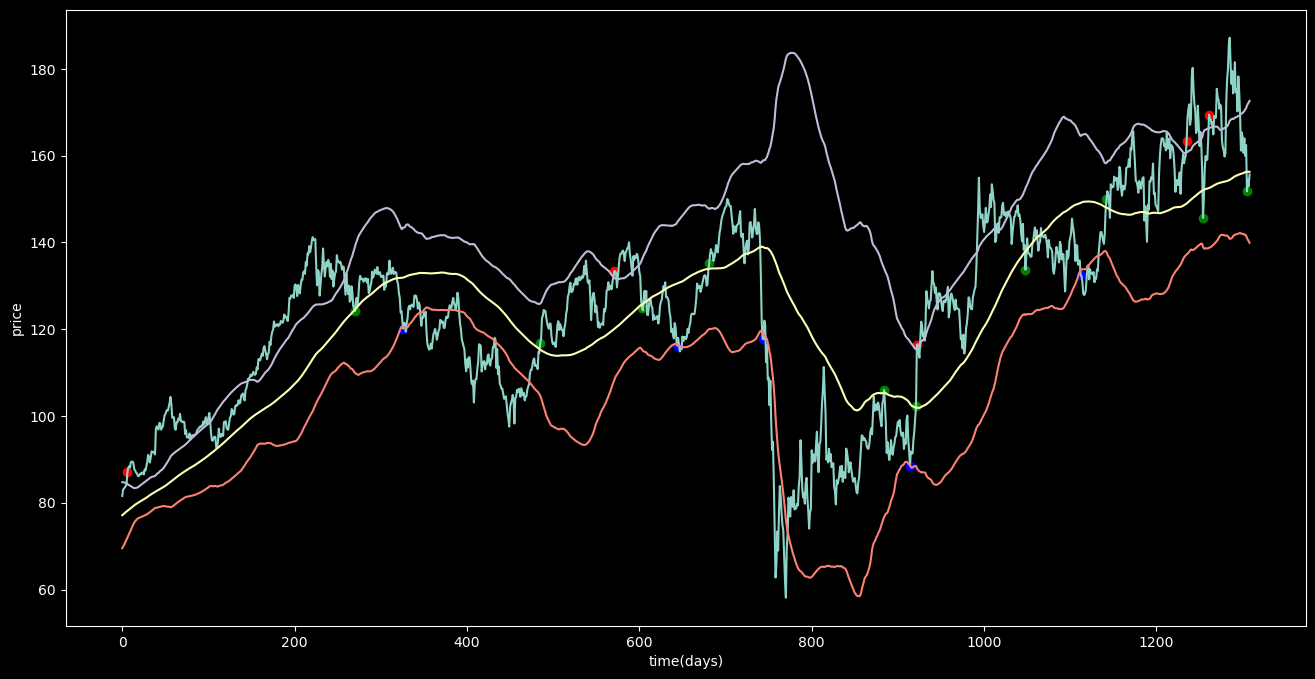

[-0.4254107227367994, -0.4524204984477052, -0.38900502273742865, -0.22558188506918916, -0.32540640463642384, -0.17068827855537494, -0.31980073997707603, -0.18816911958078789, -0.0798820128149601, 0.024515211973417272]
[-0.42541072273679936, -0.44093025024156984, -0.40547657610541377, -0.30831769275529564, -0.37736454676915465, -0.2810315562136537, -0.38823871055116577, -0.30771158072529303, -0.23274567075454666, -0.15264644807445338]


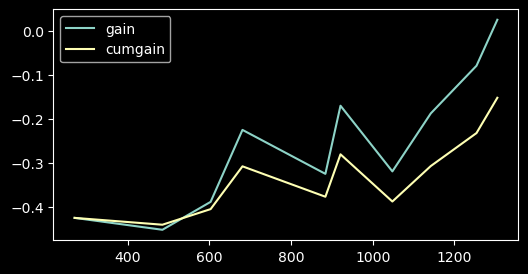

In [331]:
def trading_logic(std_val,rolling_list,t_prices_list,t_rolling_list,std_list,asset,show_plots = False):

    t_price = t_prices_list[asset]
    t_std = std_list[asset]
    rolling = rolling_list[asset]
    
    t_stdup = []
    t_stddown = []
    
    price_long = []
    time_long = []
    
    price_short = []
    time_short = []
    
    price_close = []
    time_close = []
    
    differences = []
    
    long_pos = False
    short_pos = False
    
    for t in range(len(t_price)):
        threshold_long = rolling[t]-std_val*t_std[t]
        threshold_short = rolling[t]+std_val*t_std[t]
        t_stddown.append(threshold_long)
        t_stdup.append(threshold_short)

        if t_price[t] < threshold_long and long_pos == False:
            price_long.append(t_price[t])
            time_long.append(t)
            long_pos = True
    
        if t_price[t] > threshold_short and short_pos == False:
            price_short.append(t_price[t])
            time_short.append(t)
            short_pos = True
    
        if long_pos == True and (t_price[t] > rolling[t]):# or price_long[-1] > threshold_short):
            dif = (t_price[t]-price_long[-1])/price_long[-1]
            differences.append(dif)
            price_close.append(t_price[t])
            time_close.append(t)
            long_pos = False
    
        if  short_pos == True and (t_price[t] < rolling[t]):# or price_short[-1] < threshold_long):
            dif = (price_short[-1]-t_price[t])/price_short[-1]
            differences.append(dif)
            price_close.append(t_price[t])
            time_close.append(t)
            short_pos = False
    plt.figure(figsize=(16, 8))

    if show_plots == True:      
        
        plt.plot(t_price)
        plt.plot(rolling)
        plt.plot(t_stdup)
        plt.plot(t_stddown)
        
        plt.scatter(time_short,price_short, color = "red")
        plt.scatter(time_long,price_long, color = "blue")
        plt.scatter(time_close,price_close,color = "green")
        plt.xlabel("time(days)")
        plt.ylabel("price")
        plt.show()

    gain = np.sum(differences)

    #cumulative gain: 
    cg_list = []
    g_list = []
    cg_amount = 1
    g_amount = 0
    for ret in differences: 
        cg_amount = cg_amount*(1+ret)
        g_amount = ret+g_amount
        cg_list.append(cg_amount-1)
        g_list.append(g_amount)
        
    cum_gain = cg_amount-1
    
    return(gain,cum_gain,g_list,cg_list,time_close)

asset = 57
std_val = 2
gain,cum_gain,g_list,cg_list,time_close = trading_logic(std_val,super_roll_list_train,train_prices_list,train_rolling_list,std_list,asset,show_plots = True)

print(g_list)
print(cg_list)
plt.plot(time_close, g_list,label = "gain")
plt.plot(time_close, cg_list,label = "cumgain")
plt.legend()


In [194]:
def trading_strategy_train(baskets_train,window_size,std_val,print_results = False):
    
    baskets_gain_total = []
    baskets_cum_gain_total = []
    cumulative_gain = []
    
    for basket_num in range(len(baskets_train)):
        
        stationarity, super_roll_list, t_prices_list,t_rolling_list,std_list = basket_preparation_train(baskets_train
                                ,basket_num,window_size)
    
        coefficients = stationarity_ranking(stationarity,show_plots=False)
        
        basket_gain = 0
        basket_cum_gain = 0
        
        assets = baskets_train[basket_num].columns.tolist()
        for asset in range(len(assets)):
            gain,cum_gain,g_list,cg_list,time_close = trading_logic(std_val,super_roll_list,t_prices_list,t_rolling_list,std_list,asset)
            
            basket_gain += gain*coefficients[asset]
            basket_cum_gain += cum_gain*coefficients[asset]
        
        baskets_gain_total.append(basket_gain)
        baskets_cum_gain_total.append(basket_cum_gain)

        if print_results == True:
            print("basket_gain mean",basket_gain,"and the basket_cum_gain mean",basket_cum_gain)
    
    return(np.mean(baskets_cum_gain_total))


baskets_train = stock_baskets(training_data,filtered_tickers)

window_size = 140
std_val = 0.3
total_gain = trading_strategy_train(baskets_train,window_size,std_val,print_results=True)
print(total_gain)

basket_gain mean 0.02576025667307056 and the basket_cum_gain mean 0.02772294652786433
basket_gain mean 0.13676445709068685 and the basket_cum_gain mean 0.1476889151646727
basket_gain mean 0.05921870483507159 and the basket_cum_gain mean 0.06354061577208893
basket_gain mean 0.16694868453490178 and the basket_cum_gain mean 0.18258543067187638
basket_gain mean 0.10310277715252356 and the basket_cum_gain mean 0.10991807295874828
basket_gain mean 0.10178759335808901 and the basket_cum_gain mean 0.11448969115808703
basket_gain mean 0.12383313436206565 and the basket_cum_gain mean 0.13251885012049006
basket_gain mean 0.19741089850639126 and the basket_cum_gain mean 0.22247420698242876
0.12511734116953205


In [195]:
def objective_train(x):
    window = x[0]
    std_val = x[1]
    total_gain = trading_strategy_train(baskets_train,window,std_val)
    print(total_gain)
    return(total_gain)


In [ ]:
min_window = 60
max_window = 250
step_window = 30
min_std = 0.3
max_std = 3
step_std = 0.2

window_values = np.arange(min_window, max_window, step_window)
std_values = np.arange(min_std, max_std, step_std)

# Initialize variables to store optimal values
optimal_window_train = None
optimal_std_val_train = None
max_total_gain_train = float('-inf')

landscape_value_train = []
# Perform exhaustive search
for window in tqdm(window_values):
    for std_val in std_values:
        # Evaluate the objective function
        total_gain = objective_train([window, std_val])
        landscape_value_train.append(total_gain)
        # Update optimal values if a better solution is found 
        if total_gain > max_total_gain_train:
            max_total_gain_train = total_gain 
            optimal_window_train = window
            optimal_std_val_train = std_val


Optimal Window: 90
Optimal Std_val: 0.3
Optimal Total Gain: 0.2535417155145473


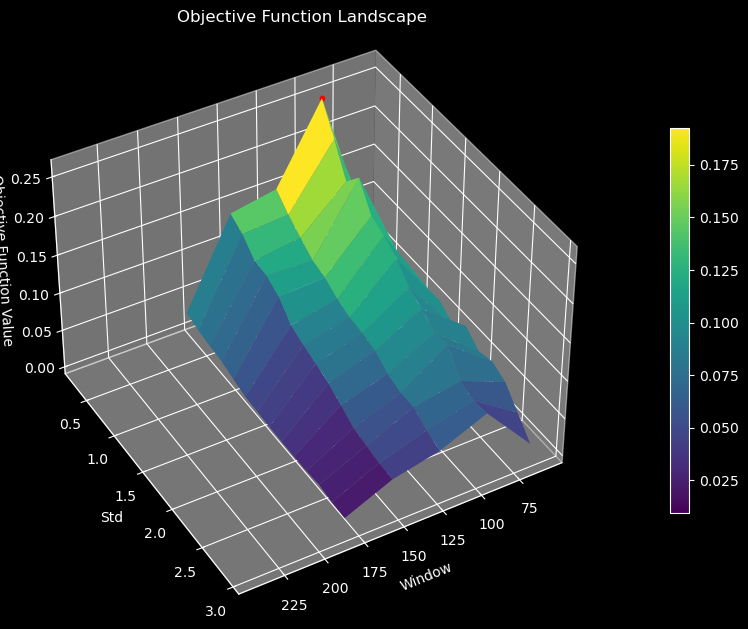

In [197]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Print the optimal values and the corresponding total gain
print("Optimal Window:", optimal_window_train)
print("Optimal Std_val:", optimal_std_val_train)
print("Optimal Total Gain:", max_total_gain_train)

# Reshape the landscape values to create a 2D array
landscape_values_2d_train = np.array(landscape_value_train).reshape( len(window_values),len(std_values))  # Note the change in the reshape dimensions

# Create 2D arrays for window and std values
std_grid, window_grid = np.meshgrid(std_values,window_values)

# Plot the 3D surface
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
surface_train = ax.plot_surface(window_grid, std_grid, landscape_values_2d_train, cmap='viridis')
ax.scatter(optimal_window_train,optimal_std_val_train,max_total_gain_train, color="red",s=10)

# Set labels and title
ax.set_xlabel('Window')
ax.set_ylabel('Std')
ax.set_zlabel('Objective Function Value')
ax.set_title('Objective Function Landscape')

colorbar = fig.colorbar(surface_train, ax=ax, pad=0.1,shrink=0.5)  # Adjust pad as needed

ax.view_init(elev=40, azim=60)  # Adjust these values to change the angle


# Show the plot
plt.show()



# TESTING

Now the test is run with the found optimal window and standard deviation parameters.

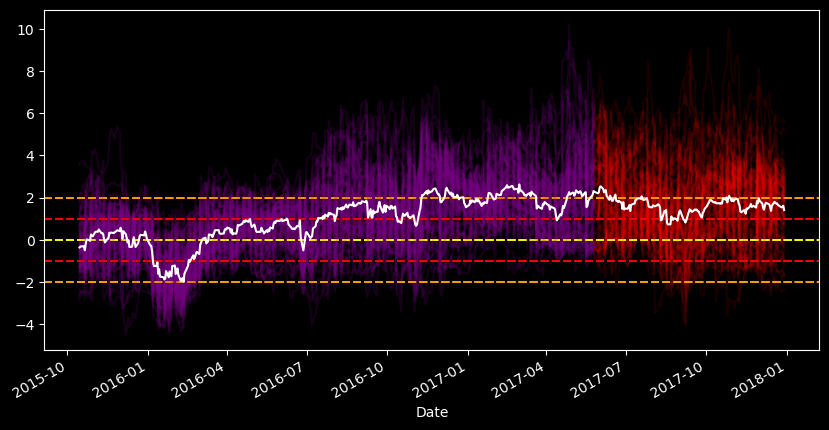

In [199]:
#stationary (Not true dynamics, it hides true price and we can't predict the future) 
#Only the red part is important, the other is training.

def super_asset_calculation_test(baskets_train,baskets_test,baskets_total,basket_num,
                                 window_size,show_plots = False, plot_super_asset = False):
    
    basket = baskets_train[basket_num]
    t_basket = baskets_test[basket_num] 
    tot_basket =  baskets_total[basket_num]
    
    assets = basket.columns.tolist()
    super_asset = pd.Series(0, index=tot_basket.index) #colum to which all indices are summed.
    
    for asset in (assets):
 
        #calculations:
        asset_price = basket[asset]
        asset_rolling = basket[asset].rolling(window_size).mean()
        std_separation = (asset_price-asset_rolling).rolling(window_size).std() #this is what is being predicted
        asset_stationary = (asset_price-asset_rolling)/std_separation 
    
        #pred:
        tot_asset_price = tot_basket[asset]
        tot_asset_rolling = tot_basket[asset].rolling(window_size).mean()
        tot_std_separation = (tot_asset_price-tot_asset_rolling).rolling(window_size).std()
        asset_tot_stationary = (tot_asset_price - tot_asset_rolling)/tot_std_separation
        super_asset += asset_tot_stationary 
        asset_sum = super_asset/len(assets)

        #plots:
        if show_plots == True:
            asset_tot_stationary.plot(color='red',alpha = 0.1)
            asset_stationary.plot(color='blue',alpha = 0.1)
        
            plt.axhline(-2, color='orange', linestyle='--',alpha = 0.1)
            plt.axhline(2, color='orange', linestyle='--',alpha = 0.1)
            plt.axhline(0, color='yellow', linestyle='--', label='Zero Line',alpha = 0.1)
            plt.axhline(1, color='red', linestyle='--',alpha = 0.1)
            plt.axhline(-1, color='red', linestyle='--',alpha = 0.1)
    
    if plot_super_asset == True:
        asset_sum.plot(color='white',alpha = 1) 
        plt.show()
    
    return(asset_sum)

basket_num = 0
window_size = 100#days (it shoudl be optimized) 

super_asset = super_asset_calculation_test(baskets_train,baskets_test,baskets_total
                          ,basket_num,window_size,show_plots=True, plot_super_asset=True)


In [ ]:
def basket_preparation_test(baskets_train,baskets_test,baskets_total,basket_num,window_size,show_plots=False
                       ,show_progress_bar=False):

    basket = baskets_train[basket_num]
    t_basket = baskets_test[basket_num] 
    tot_basket =  baskets_total[basket_num] 

    #initialize lists
    t_prices_list = []
    t_rolling_list = []
    std_list = []
    super_list = []
    stationarity = []

    #computing the super assed defined above:
    super_asset = super_asset_calculation_test(baskets_train,baskets_test,baskets_total,basket_num,window_size)

    assets = basket.columns.tolist()
    for asset in tqdm(assets,disable=not show_progress_bar):
        
        #calculations
        asset_price = basket[asset]
        asset_rolling = asset_price.rolling(window_size).mean()
        #std_separation = ((asset_price-asset_rolling)).std() #This is the predicted quantity
        std_separation = ((asset_price-asset_rolling).rolling(window_size)).std()
        asset_rolling_2stdup = asset_rolling+2*std_separation
        asset_rolling_2stddown = asset_rolling-2*std_separation 
        
        #predictions: 
        t_asset_price = t_basket[asset]
        t_asset_rolling = t_asset_price.rolling(window_size).mean()
        t_asset_rolling_2stdup = t_asset_rolling+2*std_separation
        t_asset_rolling_2stddown = t_asset_rolling-2*std_separation 
    
        #total data: 
        tot_asset_price = tot_basket[asset]
        tot_asset_rolling = tot_asset_price.rolling(window_size).mean()
        #I am changing this: 
        std_separation = ((tot_asset_price-tot_asset_rolling).rolling(window_size)).std()
        ####
        tot_asset_rolling_2stdup = tot_asset_rolling+2*std_separation
        tot_asset_rolling_2stddown = tot_asset_rolling-2*std_separation 

        #super asset:        
        super_mean = super_asset*std_separation+tot_asset_rolling
        super_mean_rolling = super_mean.rolling(window_size).mean()
        super_2stdup = super_mean_rolling+2*std_separation
        super_2stddown = super_mean_rolling-2*std_separation

        #stationarity test: 
        stationary = super_mean_rolling-tot_asset_rolling
        
        #append lists:
        super_list.append(super_mean_rolling.tolist()[len(asset_price):])       
        t_prices_list.append(t_asset_price.tolist())
        t_rolling_list.append(tot_asset_rolling.tolist()[len(asset_price):]) #we only take the test part of the total
        std_list.append(std_separation[len(asset_price):])

        stationarity.append(stationary.tolist()[:len(asset_price)])
        
        if show_plots==True: 
            #super: 
            super_mean_rolling.plot(color="white")
            super_2stdup.plot(color = 'yellow',alpha = 0.5)
            super_2stddown.plot(color = 'yellow',alpha = 0.5)
            
            #plot_predictions(red)
            t_asset_price.plot(color='red',alpha = 0.7)
            tot_asset_rolling.plot(color='green')
            tot_asset_rolling_2stdup.plot(color = 'orange',alpha = 0.5)
            tot_asset_rolling_2stddown.plot(color = 'orange',alpha = 0.5)
            
            #plot_old
            asset_price.plot(color='blue',alpha = 0.7)
            asset_rolling.plot(color='green')
            #asset_rolling_2stdup.plot(color = 'yellow',alpha = 0.5)
            #asset_rolling_2stddown.plot(color = 'yellow',alpha = 0.5)
            plt.show() 

    return(stationarity,super_list, t_prices_list,t_rolling_list,std_list)

window_size = 100 #days (it shoudl be optimized) 
basket_num = 0

stationarity, super_roll_list ,t_prices_list,t_rolling_list,std_list = basket_preparation_test(baskets_train,baskets_test,
                                                baskets_total,basket_num,window_size,show_plots=True,
                                                                            show_progress_bar = True)

print(len(super_roll_list))

"""
This gives (within a single basket):
    1. The stationarity for only the training data
    2. The super asset with a rolling window for the whole data
    3. The testing price of the assets
    4. The testing rolling price data
    5. the mean separation between the rolling and the price calculated only using training data
"""

In [202]:
def trading_strategy_test(baskets_train,baskets_test,baskets_total,window_size,std_val,print_results = False):
    
    baskets_gain_total = []
    baskets_cum_gain_total = []
    
    for basket_num in range(len(baskets_test)):

        "First the computations are done for every basket"
        stationarity,super_roll_list, t_prices_list,t_rolling_list,std_list = basket_preparation_test(baskets_train
                                ,baskets_test,baskets_total,basket_num,window_size)
        
        coefficients = stationarity_ranking(stationarity,show_plots=False)
        
        basket_gain = 0
        basket_cum_gain = 0
        
        assets = baskets_test[basket_num].columns.tolist()
        for asset in range(len(assets)):
            gain,cum_gain,g_list,cg_list,time_close = trading_logic(std_val,super_roll_list,t_prices_list,t_rolling_list,std_list,asset)
            basket_gain += gain*coefficients[asset]
            basket_cum_gain += cum_gain*coefficients[asset]
        
        baskets_gain_total.append(basket_gain)
        baskets_cum_gain_total.append(basket_cum_gain)

        if print_results == True:
            print("basket_gain mean",basket_gain,"and the basket_cum_gain mean",basket_cum_gain)
    
    return(np.mean(baskets_cum_gain_total))


baskets_train = stock_baskets(training_data,filtered_tickers)
baskets_test = stock_baskets(test_data,filtered_tickers)
baskets_total = stock_baskets(clean_data,filtered_tickers)

window_size = 60
std_val = 1.7

total_gain = trading_strategy_test(baskets_train,baskets_test,baskets_total,window_size,std_val,print_results=True)
print(total_gain)

/var/folders/hp/q_klnbms2jl9bdk4_hck_16h0000gn/T/ipykernel_1231/3597957343.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  threshold_long = rolling[t]-std_val*t_std[t]
/var/folders/hp/q_klnbms2jl9bdk4_hck_16h0000gn/T/ipykernel_1231/3597957343.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  threshold_short = rolling[t]+std_val*t_std[t]


basket_gain mean 0.08712861376069252 and the basket_cum_gain mean 0.09067052998052437
basket_gain mean 0.03529614359947459 and the basket_cum_gain mean 0.03606077015350929
basket_gain mean 0.05362733799263336 and the basket_cum_gain mean 0.05530507226286092
basket_gain mean 0.07418715337823668 and the basket_cum_gain mean 0.07562341649828314
basket_gain mean 0.04659887186202179 and the basket_cum_gain mean 0.04855141601856683
basket_gain mean 0.07792064965529308 and the basket_cum_gain mean 0.08311180057810519
basket_gain mean 0.07442123521869878 and the basket_cum_gain mean 0.07411529367054999
basket_gain mean 0.1245647255567466 and the basket_cum_gain mean 0.12868012450305064
0.0740148029581813


In [203]:
def objective_test(x):
    window = x[0]
    std_val = x[1]
    total_gain = trading_strategy_test(baskets_train,baskets_test,baskets_total,window,std_val)
    print(total_gain)
    return(total_gain)

x0 = [optimal_window_train,optimal_std_val_train]
objective_test(x0)

/var/folders/hp/q_klnbms2jl9bdk4_hck_16h0000gn/T/ipykernel_1231/3597957343.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  threshold_long = rolling[t]-std_val*t_std[t]
/var/folders/hp/q_klnbms2jl9bdk4_hck_16h0000gn/T/ipykernel_1231/3597957343.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  threshold_short = rolling[t]+std_val*t_std[t]


0.10054030057291641


0.10054030057291641

In [ ]:
min_window = 60
max_window = 250
step_window = 30
min_std = 0.3
max_std = 3
step_std = 0.2


window_values = np.arange(min_window, max_window, step_window)
std_values = np.arange(min_std, max_std, step_std)

# Initialize variables to store optimal values
optimal_window_test = None
optimal_std_val_test = None
max_total_gain_test = float('-inf')

landscape_value_test = []
# Perform exhaustive search
for window in tqdm(window_values):
    for std_val in std_values:
        # Evaluate the objective function
        total_gain = objective_test([window, std_val])
        landscape_value_test.append(total_gain)
        
        # Update optimal values if a better solution is found 
        if total_gain > max_total_gain_test:
            max_total_gain_test = total_gain 
            optimal_window_test = window
            optimal_std_val_test = std_val
            

Optimal Window: 60
Optimal Std_val: 0.3
Optimal Total Gain: 0.12133692965154182


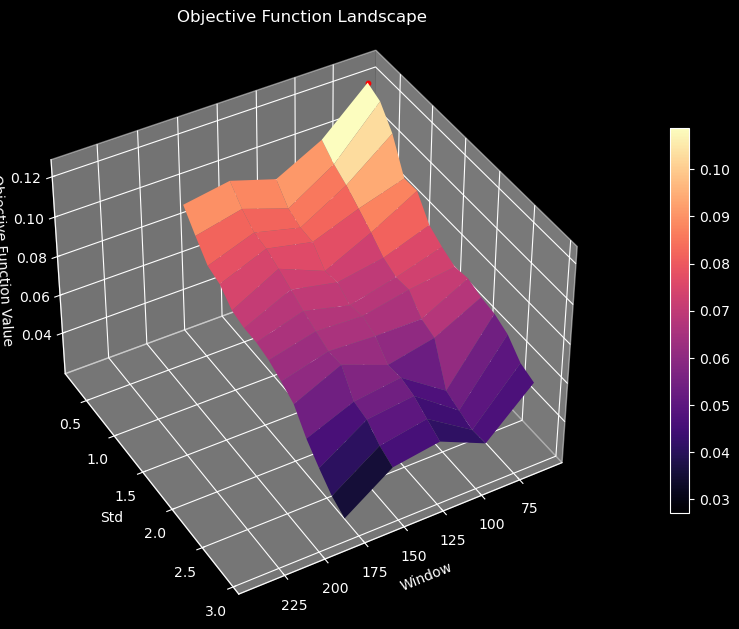

In [205]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Print the optimal values and the corresponding total gain
print("Optimal Window:", optimal_window_test)
print("Optimal Std_val:", optimal_std_val_test)
print("Optimal Total Gain:", max_total_gain_test)

# Reshape the landscape values to create a 2D array
landscape_values_2d_test = np.array(landscape_value_test).reshape( len(window_values),len(std_values))  # Note the change in the reshape dimensions

# Create 2D arrays for window and std values
std_grid, window_grid = np.meshgrid(std_values,window_values)

# Plot the 3D surface
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(window_grid, std_grid, landscape_values_2d_test, cmap='magma')
#ax.plot_surface(window_grid, std_grid, landscape_values_2d, cmap='magma')
ax.scatter(optimal_window_test,optimal_std_val_test,max_total_gain_test, color="red",s=10)

colorbar = fig.colorbar(surface, ax=ax, pad=0.1,shrink=0.5)  # Adjust pad as needed

# Set labels and title
ax.set_xlabel('Window')
ax.set_ylabel('Std')
ax.set_zlabel('Objective Function Value')
ax.set_title('Objective Function Landscape')

ax.view_init(elev=40, azim=60)  # Adjust these values to change the angle

# Show the plot
plt.show()


In [206]:
print("If I invest at",inv_time,"the PCT change is:",np.mean(final_prices))


If I invest at 603 the PCT change is: 0.17048104526786814


Future work: We should be able to compute the risk of the gain curves of each stock. We could even average the curves for every group and optimize the porfolio this way
